<a href="https://colab.research.google.com/github/celimo/Tarea4_IA/blob/main/Tarea4_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install control

In [2]:
import control as co # Trabajar sistemas de control
from control.matlab import * # Utilizar un entorno similar al de matlab
import numpy as np # Trabajar con matrices
import matplotlib.pyplot as plt # Imprimir resultados
import random # Generar números aleatorios

In [3]:
" Definición de la función de transferencia del sistema "

def fun_Tran(Inp):
  s = tf('s')

  A = Inp[0]
  B = Inp[1]
  C = Inp[2]
  D2 = Inp[3][0]
  F = Inp[4]
  K = Inp[5]

  G1 = (A[0]) / (B[0]*s**2 + B[0]*C[0]*s)
  G2 = (A[1]*s) / (B[1]*s**2 + B[1]*C[1] + D2)
  G3 = (A[2]*s**2 + A[2]*C[2]*s) / (B[2])

  H1 = F[0]*K[0]*s + K[0]
  H2 = F[1]*K[1]*s**2 + K[1]*s
  H3 = K[2]*s 

  num = G1*G2*G3 + G1*H1*G3
  den = 1 + G1*G2*G3 + G2*H2 + G2*H3 + H1*H3 + G1*H1*G3

  funct = num/den

  return funct


         3.707e+09 s^17 + 1.115e+11 s^16 + 1.404e+12 s^15 + 1.075e+13 s^14 + 6.445e+13 s^13 + 3.195e+14 s^12 + 1.248e+15 s^11 + 4.261e+15 s^10 + 1.226e+16 s^9 + 2.69e+16 s^8 + 6.058e+16 s^7 + 6.706e+16 s^6 + 1.201e+17 s^5 + 1.04e+16 s^4
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4.448e+11 s^18 + 1.251e+13 s^17 + 1.502e+14 s^16 + 1.128e+15 s^15 + 6.709e+15 s^14 + 3.271e+16 s^13 + 1.269e+17 s^12 + 4.308e+17 s^11 + 1.217e+18 s^10 + 2.699e+18 s^9 + 5.862e+18 s^8 + 6.708e+18 s^7 + 1.131e+19 s^6 + 1.094e+18 s^5 + 1.538e+16 s^4



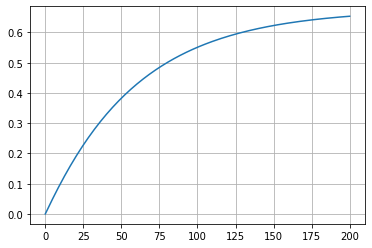

In [4]:
Cm = []

Cm.append([1,2,3])
Cm.append([4,5,6])
Cm.append([7,8,9])
Cm.append([10])
Cm.append([11,12])
Cm.append([13,14,15])

sys = fun_Tran(Cm)

print(sys)

t = np.linspace(0, 200, 1000)
t1, y1 = co.step_response(sys, t)

plt.plot(t1, y1)
plt.grid()
plt.show()

In [23]:
'''
Definición del cromosoma

Cromosoma = [[A1, A2, A3], [B1, B2, B3], [C1, C2, C3], [D2], [F1, F2], [K1, K2, K3]]

Definición del gen: Cada elemento del cromosoma es un vector con dimensiones variables

Alelos: Como primera aproximación se consideran valores entre -10 y 10
'''

# Creación de la población

def numero(a, b):
  np.random.seed()
  num = np.random.randint(a, b)
  while num == 0:
    num = np.random.randint(a, b)
  return num

num_poblacion = 100
a = -10
b = 10

pob = []

for i in range(num_poblacion):
  cromo = []
  # Ciclo para las letras A-B-C
  for j in range(3):
    temp = []
    for k in range(3):
      temp.append(numero(a, b))
    cromo.append(temp)
  cromo.append([numero(a, b)])
  temp = []
  for j in range(2):
    temp.append(numero(a, b))
  cromo.append(temp)
  temp = []
  for j in range(3):
    temp.append(numero(a, b))
  cromo.append(temp)

  pob.append(cromo)

pob = np.array(pob)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


## Función objetiva
Lo primero y más importante es si el sistema es estable, ya que de otra forma no tiene sentido el análisis

**Primer paso:** Obtener si el sistema es estable, de no serlo se asigna un valor de 1000 al error, este dato es aleatorio.

**Si es estable:**
Se obtiene el valor más alto de la respuesta al escalón unitario y se obtiene el índice de donde está. Una vez con el índice se obtiene el tiempo donde sucede ese sobreimpulso.

**La función objetiva está definida por:**

\begin{equation}
  f(\delta, t) = |\delta_r-\delta|+|t_r-t|
\end{equation}

Donde:

$\delta_r$: Sobreimpulso esperado

$\delta$: Sobreimpulso obtenido

$t_r$: Tiempo real

$t$: Tiempo obtenido

La condición final se obtiene cuando el valor de la función sea cercano a cero. Por último, el análisis se va a realizar en el tiempo $t\in[0,2]$ ya que el tiempo esperado es de 1 segundo.

In [6]:
# Se obtienen las funciones de transferencia de todos los sistemas de la población
def fun_system(pob):
  funcion = []
  for i in range(len(pob)):
    funcion.append(fun_Tran(pob[i]))
  return funcion

In [36]:
# Espacio t a analizar
t = np.linspace(0, 20, 1000)
yr = 1.2 # Valor esperado del sobreimpulso
tr = 1 # Tiempo del sobreimpulso

# Se define la función objetiva
def fun_obj(sys, yr, tr):
  resul = []

  for i in sys:
    pol = pole(i)
    cond = False
    for j in pol:
      if j.real > 1e-04:
        cond = True
        break
    if cond:
      resul.append(1000)
    else:
      te, ye = co.step_response(i, t)
      index = np.where(ye == np.amax(ye))
      resul.append(np.absolute(yr - ye[index]) + np.absolute(tr - te[index]))
  
  return resul

## Generar nueva población

En la generación de la población se parte que el conjunto seleccionado es aleatorio y el subconjunto es un número par.

La recombinación se va a realizar de forma aleatoria, en el cual se recombinan 3 genes como máximo de cada padre, donde se toman tres números enteros aleatorios comprendidos entre 0 y 5 de ahí se obtiene cual gen del cromosoma se edita.

Ya que el gen es un vector también se debe seleccionar cúal componente del vector cambiar, para este caso se va a modificar solo un valor del vector en el gen, la posición de ese vector también se va a realizar de forma aleatoria.

In [8]:
# Función para generar la nueva generación
def newGeneration(padre):
  np.random.seed() # Se crea la semilla para el aleatorio
  gen = [] # Contiene los genes que van a ser modificados
  # Se obtienen los genes a modificar, en este caso son 3
  for i in range(3):
    if i != 0: # Se asegura que no se repitan genes
      cond = True
      while cond:
        temp = []
        temp.append(np.random.randint(len(padre[0])))
        num = np.random.randint(len(padre[0][temp[-1]]))
        temp.append(num)
        cond = False
        for i in range(len(gen)):
          if gen[i][0] == temp[0] and gen[i][1] == temp[1]:
            cond = True
    else: # Caso para el primer gen a modificar
      temp = []
      temp.append(np.random.randint(len(padre[0])))
      num = np.random.randint(len(padre[0][temp[-1]]))
      temp.append(num)
    gen.append(temp)

  gen = np.array(gen)
  # Se crea el ciclo para recorrer los padres 
  for i in range(0, len(padre), 2):
    for j in range(len(gen)):
      temp = padre[i][gen[j][0]][gen[j][1]]
      padre[i][gen[j][0]][gen[j][1]] = padre[i+1][gen[j][0]][gen[j][1]]
      padre[i+1][gen[j][0]][gen[j][1]] = temp

  return padre

## Mutación de los hijos generados
Para tener mayor variabilidad se va a realizar una mutación de los hijos generados

In [9]:
# Función para realizar la mutación de los hijos
# hijos: Hijos generados a partir de los padres
# porc: Porcentaje de los hijos para mutar
def mutation(hijos, porc):
  np.random.seed() # Se crea la semilla para el aleatorio
  gen = [] # Contiene los genes que van a ser modificados
  # Se obtienen los genes a modificar, en este caso son 3
  for i in range(3):
    if i != 0: # Se asegura que no se repitan genes
      cond = True
      while cond:
        temp = []
        temp.append(np.random.randint(len(hijos[0])))
        num = np.random.randint(len(hijos[0][temp[-1]]))
        temp.append(num)
        cond = False
        for i in range(len(gen)):
          if gen[i][0] == temp[0] and gen[i][1] == temp[1]:
            cond = True
    else: # Caso para el primer gen a modificar
      temp = []
      temp.append(np.random.randint(len(hijos[0])))
      num = np.random.randint(len(hijos[0][temp[-1]]))
      temp.append(num)
    gen.append(temp)

  gen = np.array(gen)

  # Se crea el ciclo para recorrer los hijos 
  for i in range(int(len(hijos)*porc)):
    for j in range(len(gen)):
      num = np.random.normal(hijos[i][gen[j][0]][gen[j][1]], 1)
      if num < a:
        num = a
      elif num > b:
        num = b
      while num == 0:
        num = np.random.normal(hijos[i][gen[j][0]][gen[j][1]], 1)
      hijos[i][gen[j][0]][gen[j][1]] = num
  
  return hijos

## Creación del torneo de selección
Para el torneo se debe seleccionar la cantidad de individuos que van a combatir entre sí y a partir de esa selección se realiza el torneo hasta tener el total requerido.

In [10]:
# Función para realizar el torneo de la población
# pob: Población
# resul_FO: Resultado al realizar la función objetiva
# cant: Cuantos individuos de la población participan por torneo, expresado en porcentaje
def torneo(pob, resul_FO, cant):
  # Se concatena la población con los resultados de la función objetiva
  

SyntaxError: ignored